# Plots for paper

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [16]:

import matplotlib.pyplot as plt 

import numpy as np 
import json
import pandas as pd 
import corner
import scienceplots


def load_data_and_check_for_weird_values(path):



 # Opening JSON file
    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 



    extra_median = df_posterior['psi_gw'].median()
    if extra_median < 1.0: #psi is weird / not converged so don't plot it 
        #print("Ignoring this file since psi not converged",extra_median)
        return_code = 1
    else:
        return_code = 0

    return return_code


def load_data(path,variables_to_plot):

    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 
 
    return df_posterior[variables_to_plot]

In [17]:
import glob 
#list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/compressed_files/*shifted_prior*.parquet.gzip"))
list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/small_h_batch/*"))

parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h",]

list_of_well_behaved_files = []

for f in list_of_files:
    return_code = load_data_and_check_for_weird_values(f)

    if return_code == 0:
        list_of_well_behaved_files.extend([f])


#f = list_of_files[1]
#df_reference,return_code = load_data(f,parameters)

In [18]:
len(list_of_well_behaved_files) / len(list_of_files)

0.9

In [19]:
#Process all files 


parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h",]



all_arrays = []
for f in list_of_well_behaved_files:

    print(i)

    df = load_data(f,parameters)

    numpy_array = df.to_numpy()

    all_arrays.extend([numpy_array])

    i+=1

print("saving")
numpyify = np.array(all_arrays, dtype=object)
outfile = '../data/pairwise_wasserstein'
np.save(outfile, numpyify)



4005
4006
4007
4008


KeyboardInterrupt: 

In [3]:
import numpy as np 
new_data = np.load('../data/pairwise_wasserstein.npy',allow_pickle=True)

In [4]:
import itertools
indexes = list(itertools.combinations(range(len(new_data)), 2))

In [5]:
from scipy.stats import wasserstein_distance
parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h"]
wasserstein_results = np.zeros((len(indexes),len(parameters)))
i=0
for a,b in indexes:

    data1 = new_data[a]
    data2 = new_data[b]

    for p in range(len(parameters)):
        data1_slice = data1[:,p]
        data2_slice = data2[:,p]


        w = wasserstein_distance(data1_slice,data2_slice)
        wasserstein_results[i,p] += w 


    i +=1

In [7]:
print(np.median(wasserstein_results,axis=0))
parameter_scales = [5e-6,2*np.pi,2*np.pi,2*np.pi,2*np.pi,2*np.pi,1e-9]
print("Percentage medians:", 100.0*np.median(wasserstein_results,axis=0) / parameter_scales)

[1.03772738e-09 1.34206317e-01 1.69199228e-01 1.40567641e-01
 9.31052587e-02 1.68504543e-01 8.14104117e-16]
Percentage medians: [2.07545477e-02 2.13595988e+00 2.69288935e+00 2.23720348e+00
 1.48181621e+00 2.68183310e+00 8.14104117e-05]


In [6]:
print(np.median(wasserstein_results,axis=0))
parameter_scales = [5e-6,2*np.pi,2*np.pi,2*np.pi,2*np.pi,2*np.pi,1e-9]
print("Percentage medians:", 100.0*np.median(wasserstein_results,axis=0) / parameter_scales)

[1.03772738e-09 1.34206317e-01 1.69199228e-01 1.40567641e-01
 9.31052587e-02 1.68504543e-01 8.14104117e-16]
Percentage medians: [2.07545477e-02 2.13595988e+00 2.69288935e+00 2.23720348e+00
 1.48181621e+00 2.68183310e+00 8.14104117e-05]


In [8]:
psi_slice = wasserstein_results[:,2]

idx = np.argmax(psi_slice)

print(idx,psi_slice[idx])

2310 1.7257525496600863


In [9]:
print(indexes[2310])

(31, 48)


In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import json 
import pandas as pd 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

json
The evidence is: 585684.2980193564


,omega_gw,phi0_gw,psi_gw,iota_gw,delta_gw,alpha_gw,h,f00,f01,f02,...,distance40,distance41,distance42,distance43,distance44,distance45,distance46,sigma_m,log_likelihood,log_prior
0,501.906080,0.853180,1.990440,0.586516,1.189031,0.427746,0.001875,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585690.040926,4748.942335
1,498.632110,0.395345,2.136397,0.501873,0.987252,0.367431,0.001678,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585690.580727,4740.121162
2,502.637902,0.250755,2.496999,1.118508,0.785368,0.620226,0.003930,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585691.443970,4743.352447
3,498.710702,0.335196,2.387155,0.722598,0.862025,0.929496,0.002838,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585691.671294,4748.098564
4,500.424285,0.420803,2.326465,1.106406,0.957787,0.468241,0.002530,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585692.226779,4737.636719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5825,499.506493,0.229099,2.831074,0.518942,1.102256,1.156448,0.004246,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585706.844108,4746.850715
5826,499.399794,0.214826,2.812906,0.588639,1.123956,1.140792,0.004342,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585706.867860,4743.522239
5827,499.312598,0.182699,2.848049,0.378714,1.100792,1.152162,0.004229,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585706.886792,4739.693771
5828,499.333009,0.160144,2.885851,0.521698,1.130719,1.164455,0.004344,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585706.902574,4754.419718


Number of samples:
5830
Truths/Medians/Variances
$\Omega [\text{nHz}]$ 500.0 500.1690651370484 1.1822292345949528
$\Phi_0$ 0.2 0.3809019477296131 0.04893410779646042
$\psi$ 2.5 2.7501918853958958 0.03670978842906515
$\iota$ 1.0 0.7430125555335713 0.11097198674582236
$\delta$ 1.0 1.1251799482363893 0.00662286402215411
$\alpha$ 1.0 1.077657275416011 0.03952198059007611
$h_{0, \times 10^{12}}$ 0.005248074602497734 0.004256585249381847 1.174815144316641e-06
running with increased label size


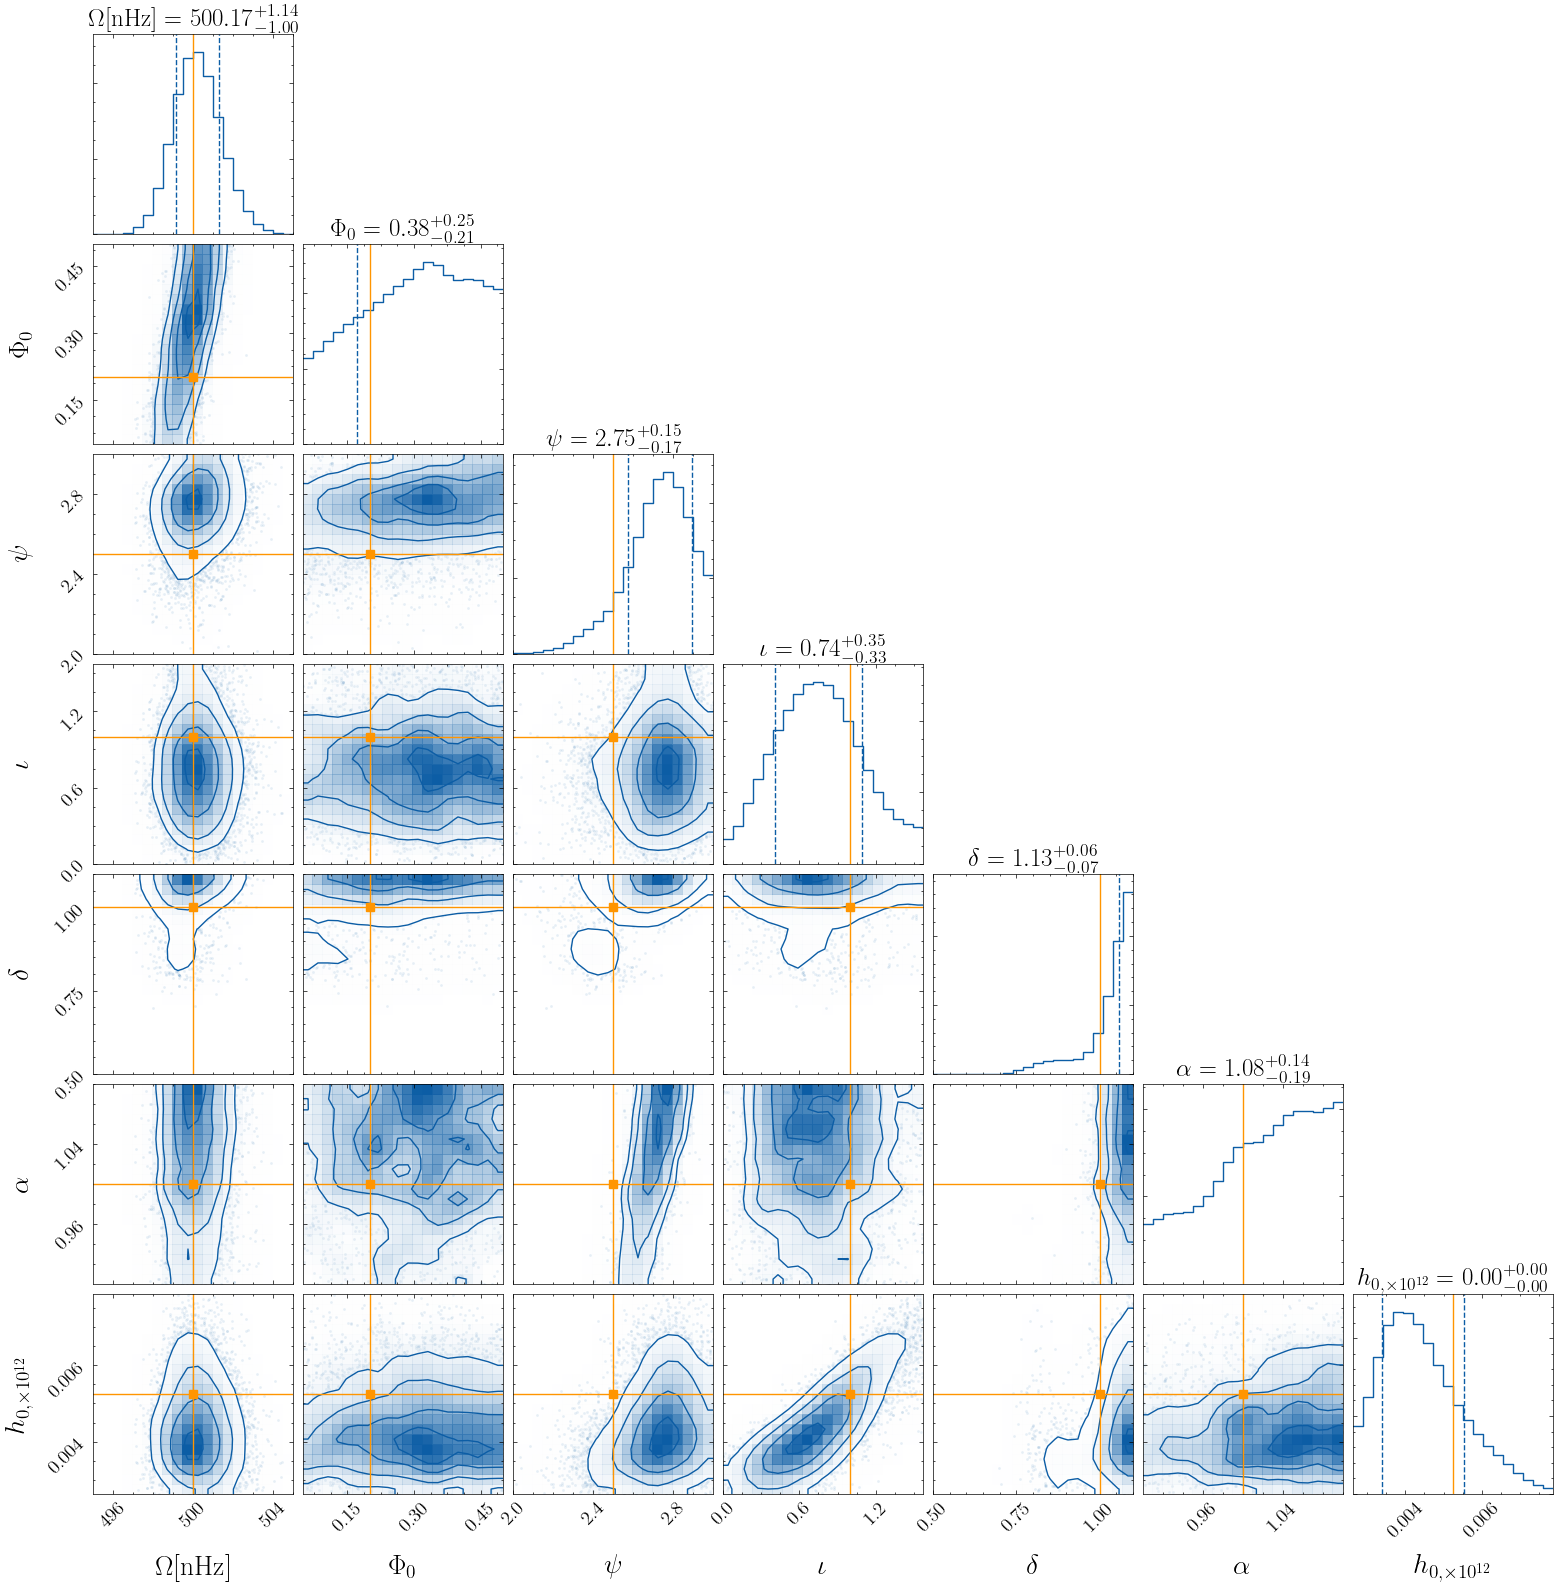

**********************************************************************


In [21]:
#Plot these two guys

from plotting import plot_custom_corner



path = list_of_well_behaved_files[31]

val = 5e-15


ranges=[(495,505),(0.05,0.50),(2.0,3.0),(0.0,np.pi/2.0),(0.5,1.1),(0.9,1.1),(0.5*5.248074602497734e-15*1e12,1.5*5.248074602497734e-15*1e12)]
injection_parameters = [5e-7*1e9,0.20,2.50,1.0,1.0,1.0,5.248074602497734e-15*1e12]
labels = [r'$\Omega [\text{nHz}]$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'$h_{0, \times 10^{12}}$']
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
axes_scales = None
#Corner plot of GW parameters
plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=None)











json
The evidence is: 585878.3976726267


,omega_gw,phi0_gw,psi_gw,iota_gw,delta_gw,alpha_gw,h,f00,f01,f02,...,distance40,distance41,distance42,distance43,distance44,distance45,distance46,sigma_m,log_likelihood,log_prior
0,502.851977,0.565492,0.797985,1.086519,0.979877,2.366055,0.006917,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585883.246939,4764.594098
1,498.532359,0.431195,1.119183,0.660101,0.768027,2.950612,0.004785,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585884.694190,4738.196250
2,499.280481,0.341467,0.928030,1.146455,0.610529,2.898712,0.008474,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585885.370412,4759.379599
3,501.069646,0.700314,0.820732,0.053244,0.846145,2.809030,0.004833,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585885.627785,4752.460495
4,502.623841,0.400751,1.067927,0.500798,0.647513,2.541637,0.005253,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585886.331143,4756.950703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,499.481876,0.223809,0.983584,0.185036,0.828545,2.681674,0.005232,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.551322,4751.296314
4532,500.042053,0.291222,0.984214,1.104226,0.815686,2.692800,0.009260,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.574696,4749.513869
4533,499.932878,0.284062,1.009705,1.416857,0.810633,2.679448,0.010354,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.628677,4736.214864
4534,500.232798,0.320872,0.979185,1.203005,0.826793,2.683527,0.009098,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.632818,4741.628366


Number of samples:
4536
Truths/Medians/Variances
$\Omega [\text{nHz}]$ 500.0 500.2994982154439 0.8146137669933717
$\Phi_0$ 0.2 0.3453872031125076 0.02324157504696552
$\psi$ 2.5 1.0072462627288092 0.003603471094347507
$\iota$ 1.0 0.8438538277790862 0.12658104624949149
$\delta$ 1.0 0.7774952273709569 0.00559943494309619
$\alpha$ 1.0 2.7047306182555135 0.0027837696339335456
$h_{0, \times 10^{12}}$ 0.005248074602497734 0.006939023985450714 2.5979153139773495e-06
running with increased label size


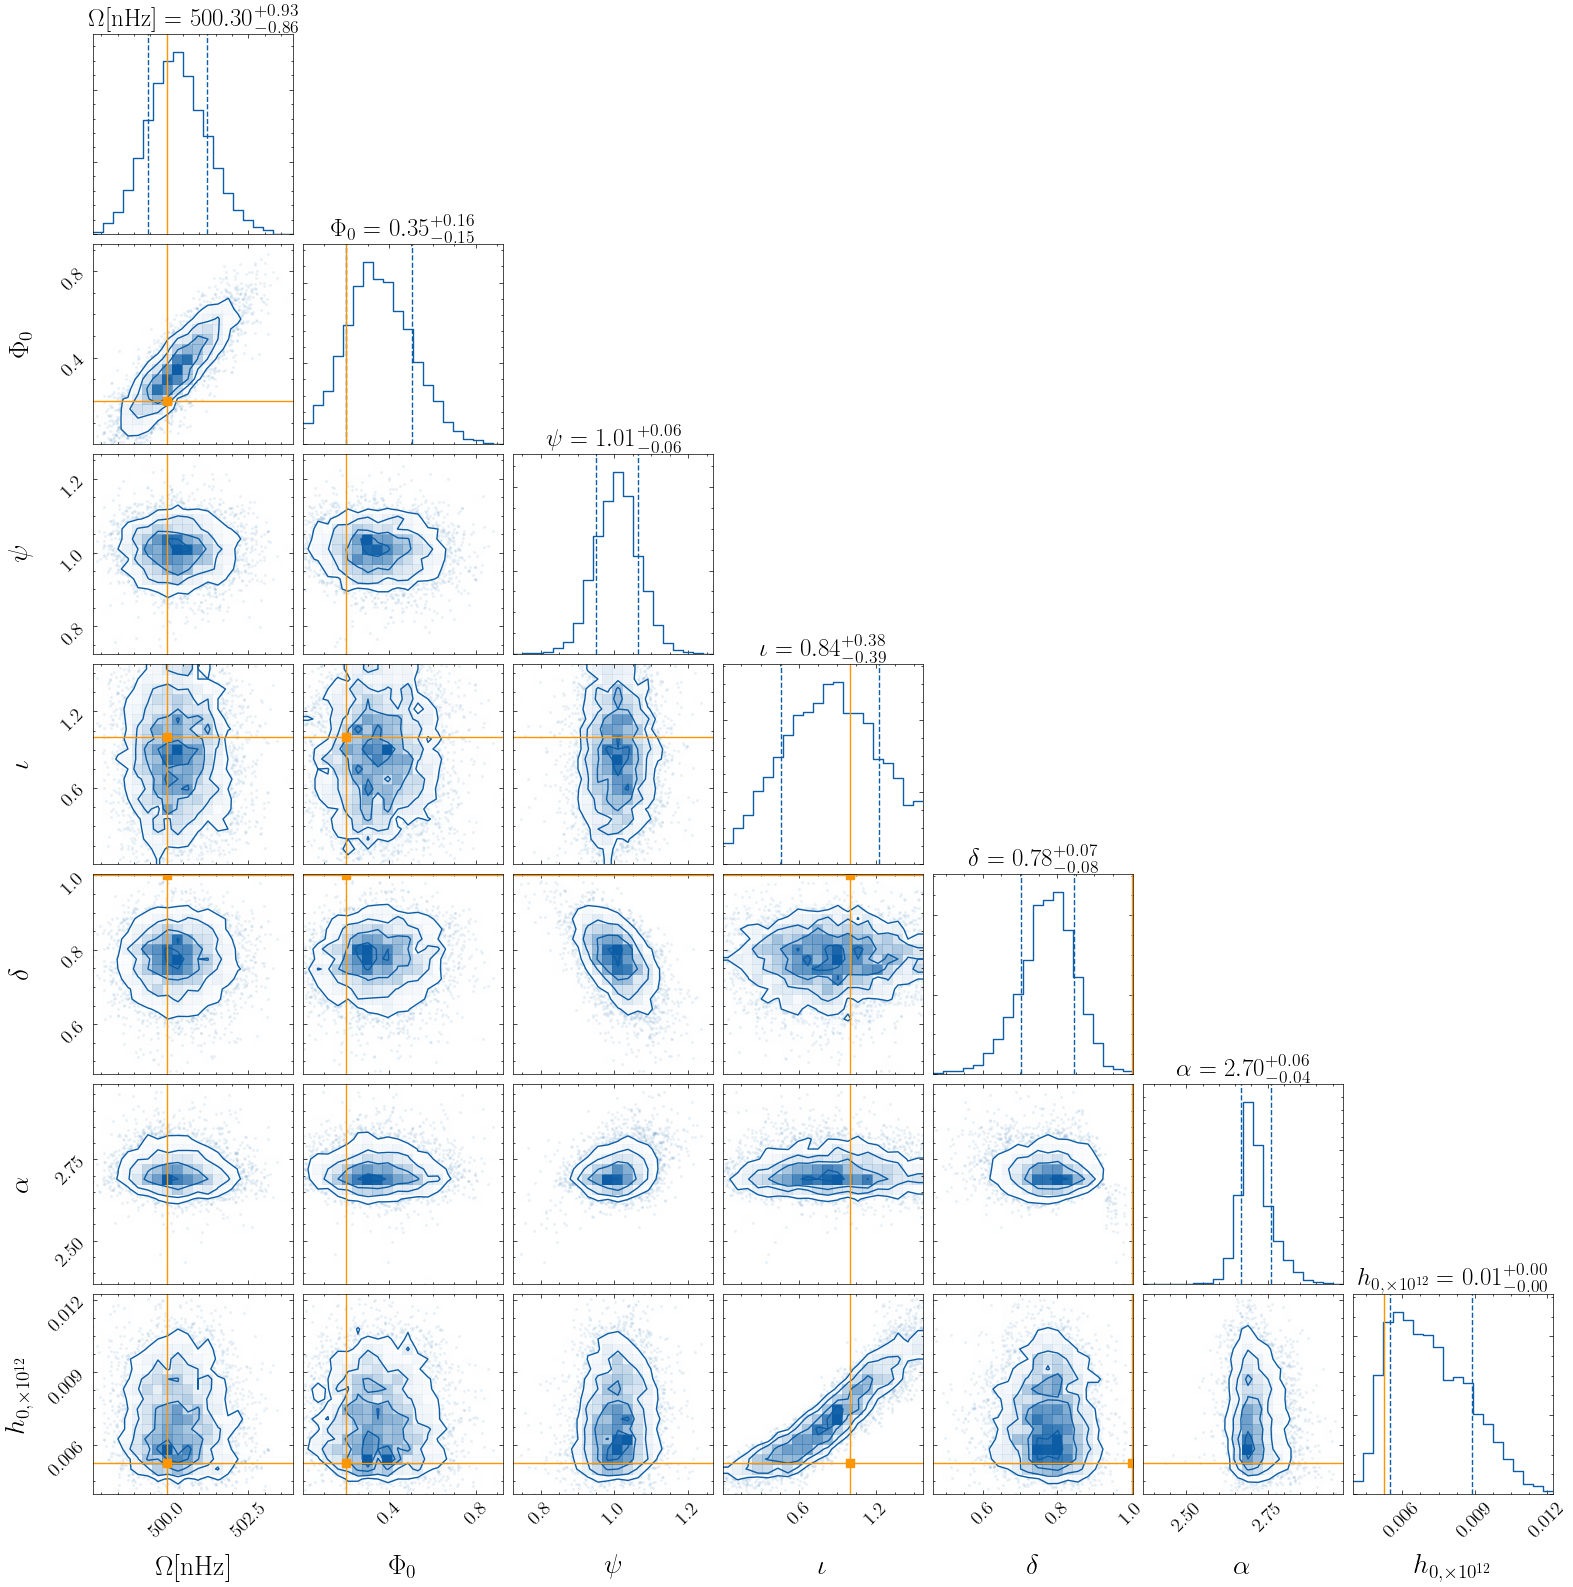

**********************************************************************


In [25]:
#Plot these two guys

from plotting import plot_custom_corner



path = list_of_well_behaved_files[48]

val = 5e-15


#ranges=[(495,505),(0.05,0.50),(2.0,3.0),(0.0,np.pi/2.0),(0.5,1.1),(0.9,1.1),(0.5*5.248074602497734e-15*1e12,1.5*5.248074602497734e-15*1e12)]
ranges=None
injection_parameters = [5e-7*1e9,0.20,2.50,1.0,1.0,1.0,5.248074602497734e-15*1e12]
labels = [r'$\Omega [\text{nHz}]$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'$h_{0, \times 10^{12}}$']
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
axes_scales = None
#Corner plot of GW parameters
plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=None)











json
The evidence is: 585878.3976726267


,omega_gw,phi0_gw,psi_gw,iota_gw,delta_gw,alpha_gw,h,f00,f01,f02,...,distance40,distance41,distance42,distance43,distance44,distance45,distance46,sigma_m,log_likelihood,log_prior
0,502.851977,0.565492,0.797985,1.086519,0.979877,2.366055,0.006917,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585883.246939,4764.594098
1,498.532359,0.431195,1.119183,0.660101,0.768027,2.950612,0.004785,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585884.694190,4738.196250
2,499.280481,0.341467,0.928030,1.146455,0.610529,2.898712,0.008474,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585885.370412,4759.379599
3,501.069646,0.700314,0.820732,0.053244,0.846145,2.809030,0.004833,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585885.627785,4752.460495
4,502.623841,0.400751,1.067927,0.500798,0.647513,2.541637,0.005253,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585886.331143,4756.950703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,499.481876,0.223809,0.983584,0.185036,0.828545,2.681674,0.005232,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.551322,4751.296314
4532,500.042053,0.291222,0.984214,1.104226,0.815686,2.692800,0.009260,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.574696,4749.513869
4533,499.932878,0.284062,1.009705,1.416857,0.810633,2.679448,0.010354,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.628677,4736.214864
4534,500.232798,0.320872,0.979185,1.203005,0.826793,2.683527,0.009098,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585898.632818,4741.628366


Number of samples:
4536
Truths/Medians/Variances
$\psi$ 2.5 1.0072462627288092 0.003603471094347507
running with increased label size


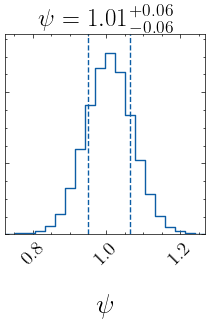

**********************************************************************


In [24]:
#Plot these two guys

from plotting import plot_custom_corner



path = list_of_well_behaved_files[48]

val = 5e-15


#ranges=[(495,505),(0.05,0.50),(2.0,3.0),(0.0,np.pi/2.0),(0.5,1.1),(0.9,1.1),(0.5*5.248074602497734e-15*1e12,1.5*5.248074602497734e-15*1e12)]
ranges=None
injection_parameters = [2.50]
labels = [r'$\psi$']
variables_to_plot = ["psi_gw"]
axes_scales = None
#Corner plot of GW parameters
plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=None)











In [105]:
from matplotlib import ticker, cm
import matplotlib.pyplot as plt 
import seaborn as sns 
import scienceplots





plt.style.use('seaborn')



def plot_wasserstein_pairs(data,idx,use_axes_limits=True,title='$\Omega$'):

    #Get the data
    data_slice = data[:,idx]

    #Make it a 2D numpy array
    size_X = 90
    X = np.zeros((size_X,size_X))
    X[np.triu_indices(X.shape[0], k = 1)] = data_slice
    X = X + X.T
    
    #Create a mask since symmetric
    mask = np.zeros_like(X, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = 'magma' 


    #Setup figure
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)


    if use_axes_limits:
        vmax=np.max(X)
    else:
        vmax = 0.50

    
    sns.heatmap(X, mask=mask, cmap=cmap, vmax=vmax, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9},ax=ax)
    #ax.figure.axes[-1].yaxis.label.set_size(20)


    #ax.figure.axes[-1].set_title('dfdfdff')

    cbar = ax.collections[0].colorbar
    cbar.set_label('$W_1$', labelpad=20,rotation=0,fontsize=20)
    cbar.ax.tick_params(labelsize=20-4) 
    #cbar.label.set_size(20)


    #ax.figure.axes[0].set_major_locator(plt.MaxNLocator(20))

    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])


    #ax.set_title(title)  
    outfile = f'WD_{idx}'
    plt.savefig(f"../data/images/{outfile}.png", bbox_inches="tight",dpi=300)

    plt.savefig('')
    plt.show()


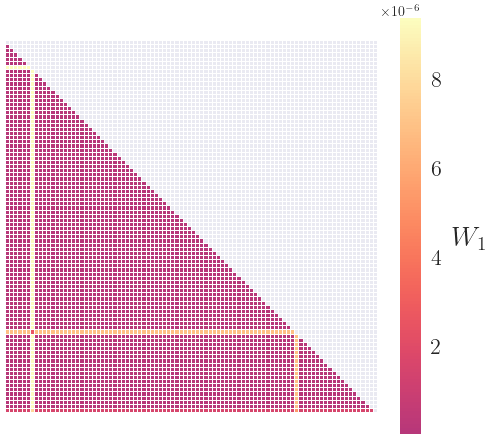

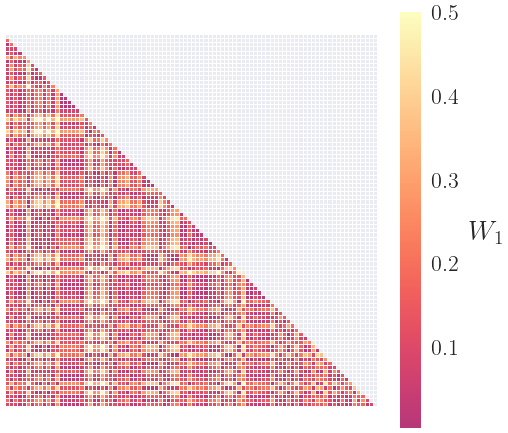

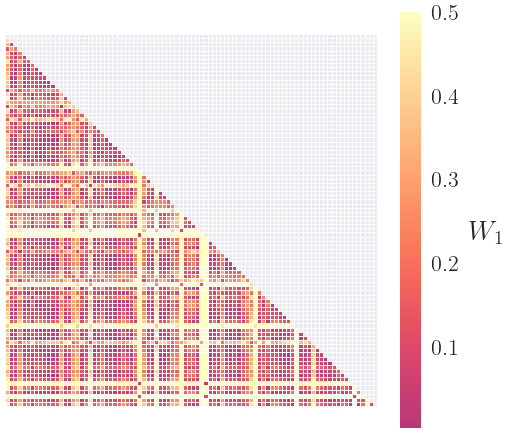

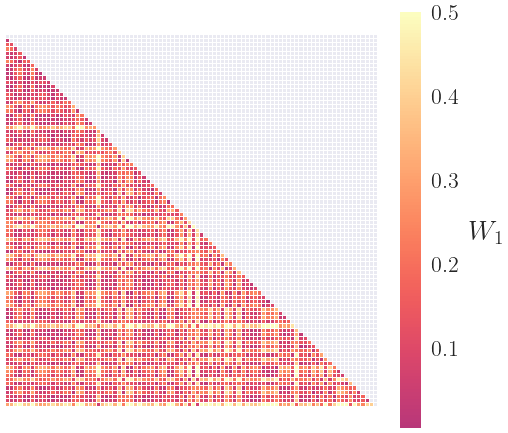

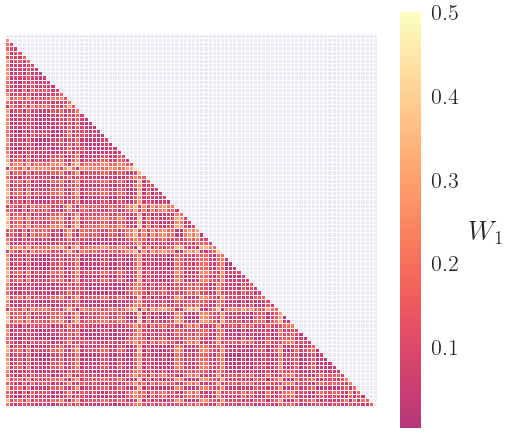

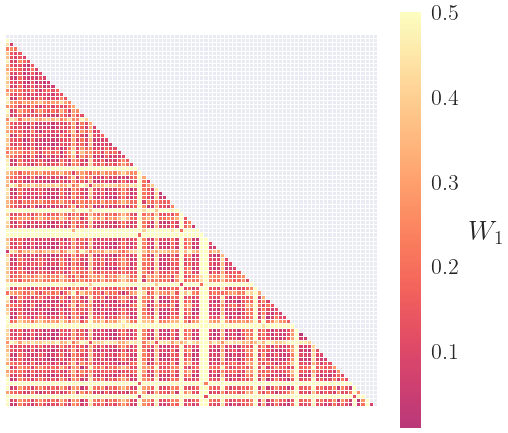

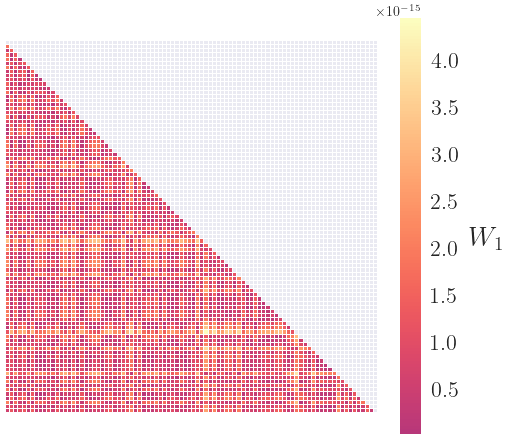

In [106]:
labels = ['$\Omega$','$\Phi_0$','$\psi$','$\iota$', '$\delta$','$\\alpha$','$h_0$']
#labels = ['$\Omega$','$\Omega$','$\Omega$','$\Omega$','$\Omega$','$\Omega$','$\Omega$']
use_axes_limits = [True,False,False,False,False,False,True]
for i in range(len(parameters)):
    plot_wasserstein_pairs(wasserstein_results,i,use_axes_limits=use_axes_limits[i],title=labels[i])

In [34]:

import scipy.stats
scipy.stats.pearsonr(wasserstein_results[:,2], wasserstein_results[:,5])    # Pearson's r

PearsonRResult(statistic=0.9625174732842687, pvalue=0.0)

In [106]:
wasserstein_results.shape

(4005, 7)

In [109]:
wasserstein_results[:,3]

array([0.0378577 , 0.15433196, 0.22777011, ..., 0.03917736, 0.41657718,
       0.39991208])

In [85]:
phi0_wasser = wasserstein_results[:,1]

In [86]:
phi0_wasser.shape

(4005,)

In [ ]:
phi0_wasser_reshaped = phi0_wasser.reshape()

In [121]:
np.min(phi0_wasser)

0.0031327035398833057

0.5791704394959557
0.0


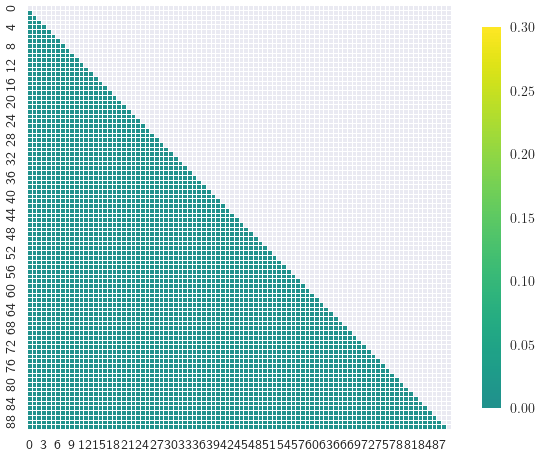

In [127]:
plt.style.use('seaborn')

#Get the data
phi0_wasser = wasserstein_results[:,1]

#Make it a 2D numpy array
size_X = 90
X = np.zeros((size_X,size_X))
X[np.triu_indices(X.shape[0], k = 1)] = phi0_wasser


#Create a mask since symmetric
mask = np.zeros_like(X, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = 'viridis' 

print(np.max(X))
print(np.min(X))



ax = sns.heatmap(X, mask=mask, cmap=cmap,vmin=0.0,vmax=0.30, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .9})

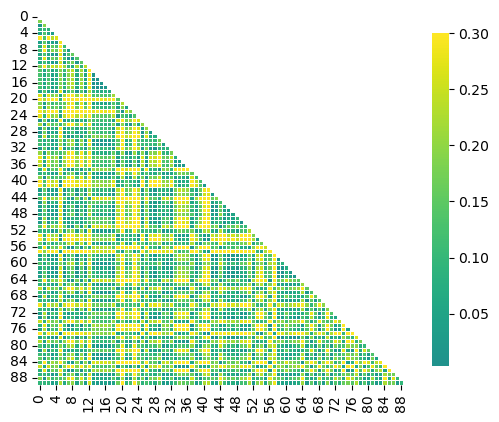

In [100]:

mask = np.zeros_like(X, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = 'viridis' 

ax = sns.heatmap(X, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9})


In [88]:
len(indexes)

4005

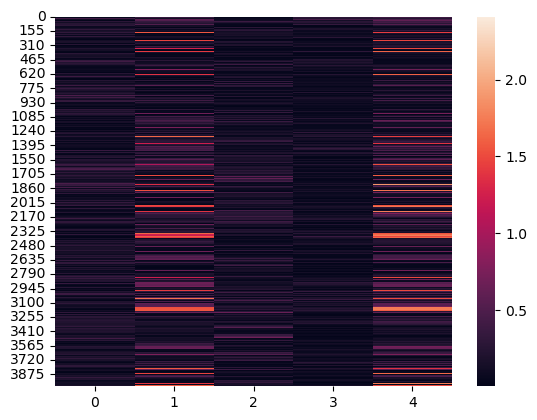

In [80]:

import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(angular_wassersteins)
plt.show()



In [ ]:
def process_files():

    #Load pandas df
   


    #Make it a np array
    numpy_array = df.to_numpy()

    #Save to file

In [14]:
f = list_of_well_behaved_files[0]
df_reference = load_data(f,parameters)

In [17]:
import sys 
from scipy.stats import wasserstein_distance


wasserstein_results = np.zeros((len(list_of_well_behaved_files)-1,len(parameters)))
for i in range(1,len(list_of_well_behaved_files)):
    print(len(list_of_well_behaved_files) - i)
    f = list_of_well_behaved_files[i]
    df = load_data(f,parameters)
    k = 0
    for p in parameters:
    
        w = wasserstein_distance(df_reference[p].to_numpy(),df[p].to_numpy())
        wasserstein_results[i-1,k] += w 
        k += 1


    

89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [18]:
wasserstein_results

array([[2.33762205e-09, 1.85793466e-01, 4.17163916e-01, 3.78576986e-02,
        2.72200288e-01, 4.95478257e-01, 1.80396929e-15],
       [3.33474481e-09, 5.29873931e-03, 3.29721354e-01, 1.54331957e-01,
        1.88488160e-01, 4.39366731e-01, 3.96422191e-16],
       [2.87603511e-09, 8.41876446e-02, 1.20435261e-01, 2.27770106e-01,
        1.67126081e-01, 2.32860026e-01, 1.59092618e-15],
       [1.87317742e-09, 5.22695443e-02, 3.34526571e-01, 8.30884199e-02,
        3.00919846e-01, 3.72490521e-01, 1.79944499e-15],
       [3.77517993e-09, 3.19794047e-01, 2.85595568e-01, 7.61286989e-02,
        1.29696686e-01, 3.70372983e-01, 5.81118317e-16],
       [9.36614904e-06, 3.69796665e-02, 4.54768595e-01, 2.42415977e-01,
        3.14875043e-01, 4.65051655e-01, 1.88822500e-15],
       [1.33088207e-09, 7.12594361e-02, 2.89649182e-01, 6.80122336e-02,
        2.30735287e-01, 3.61292269e-01, 4.44071591e-16],
       [1.05317124e-09, 1.04630016e-01, 3.01233160e-01, 3.01081922e-02,
        2.55854264e-01, 3

array([1.85106425e-09, 1.04630016e-01, 3.67648143e-01, 1.20051528e-01,
       2.58112801e-01, 3.97526468e-01, 1.12204622e-15])

In [20]:
np.median(wasserstein_results,axis=0)
injection_parameters = [5e-7,0.20,2.50,1.0,1.0,1.0,5e-15]
np.median(wasserstein_results,axis=0) / injection_parameters


array([0.00370213, 0.52315008, 0.14705926, 0.12005153, 0.2581128 ,
       0.39752647, 0.22440924])

In [38]:
df = load_data(f,parameters)

In [39]:
df

,omega_gw,phi0_gw,psi_gw,iota_gw,delta_gw,alpha_gw,h
0,5.000001e-07,0.193300,2.595132,0.758582,1.001830,1.038984,1.062884e-12
1,4.999990e-07,0.195338,2.594946,0.914982,1.001852,1.038783,1.183517e-12
2,5.000085e-07,0.195745,2.596255,0.743157,1.002767,1.039714,1.052433e-12
3,5.000015e-07,0.195423,2.596508,0.827010,1.002305,1.039820,1.114980e-12
4,4.999917e-07,0.192893,2.595399,0.968847,1.001697,1.039041,1.229464e-12
...,...,...,...,...,...,...,...
11605,5.000000e-07,0.194168,2.595424,1.013730,1.001215,1.038944,1.270089e-12
11606,4.999969e-07,0.193350,2.596211,0.977245,1.002433,1.039815,1.236280e-12
11607,4.999981e-07,0.193549,2.596407,0.939210,1.002701,1.039909,1.204758e-12
11608,4.999961e-07,0.194011,2.595116,0.887927,1.001503,1.039113,1.161320e-12


In [ ]:
ws_df = df.groupby('grp').apply(lambda x: stats.wasserstein_distance(x['p'], x['q']))


In [17]:
from scipy.stats import wasserstein_distance

var = "h"
wasserstein_distance(df_reference[var].to_numpy(),df[var].to_numpy())



1.1943624520184697e-13